In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit
import pickle

---

In [2]:
#First we read collected and already cleaned data
#marburg = pd.read_csv("../data_0/marburg.csv")
#duisburg = pd.read_csv("../data_0/duisburg.csv")
#marburg_weather = pd.read_csv("../data_0/weather/marburg_weather.csv")
#duisburg_weather = pd.read_csv("../data_0/weather/duisburg_weather.csv")

# KPIs

## Utilization / Peak Utilization (Anne)

### Marburg

In [3]:
#Read in data
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
fleet_size = len(marburg["b_number"].unique())
marburg
kpi_mar = pd.DataFrame()

In [4]:
#setting start and end date of the trips (start is rounded down hourly)
marburg["start"] = marburg.index.floor(freq = "H")
marburg['end'] = marburg.index + pd.to_timedelta(marburg['trip_duration_mins'], unit='m')
marburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,start,end
datetime,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,2019-07-04 13:00:00,2019-07-04 14:10:00
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,2019-07-06 16:00:00,2019-07-06 17:12:00
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,2019-07-06 17:00:00,2019-07-06 18:19:00
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,2019-07-06 20:00:00,2019-07-06 20:41:00
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,2019-07-07 08:00:00,2019-07-07 08:59:00
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19 12:57:00,2019-05-19,12:57:00,91116,marburg,"(50.8279, 8.7751)","(50.8137, 8.7707)",6,12,20,2019-05-19 12:00:00,2019-05-19 13:17:00
2019-05-19 21:41:00,2019-05-19,21:41:00,91116,marburg,"(50.8137, 8.7707)","(50.8229, 8.7747)",6,21,7,2019-05-19 21:00:00,2019-05-19 21:48:00
2019-05-20 06:56:00,2019-05-20,06:56:00,91116,marburg,"(50.8229, 8.7747)","(50.82, 8.7737)",0,6,3,2019-05-20 06:00:00,2019-05-20 06:59:00


In [5]:
#computing availablility by grouping by datetime and checking the number of diiferent bike numbers
kpi_mar["util"]  = marburg.groupby("start")["b_number"].nunique()
kpi_mar["util"]

start
2019-01-20 00:00:00     6
2019-01-20 01:00:00     8
2019-01-20 02:00:00     5
2019-01-20 03:00:00     1
2019-01-20 04:00:00     2
                       ..
2020-01-20 19:00:00    30
2020-01-20 20:00:00    25
2020-01-20 21:00:00    15
2020-01-20 22:00:00     9
2020-01-20 23:00:00     4
Name: util, Length: 8345, dtype: int64

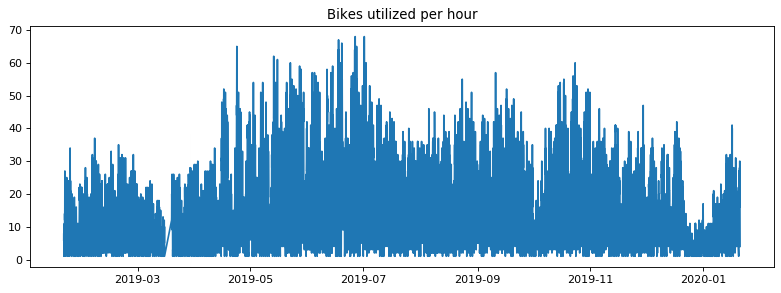

In [6]:
#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_mar["util"])
ax.set_title("Bikes utilized per hour")
plt.show()

In [7]:
#creating day column
kpi_mar["date"] = kpi_mar.index.date
kpi_mar

,util,date
start,,
2019-01-20 00:00:00,6,2019-01-20
2019-01-20 01:00:00,8,2019-01-20
2019-01-20 02:00:00,5,2019-01-20
2019-01-20 03:00:00,1,2019-01-20
2019-01-20 04:00:00,2,2019-01-20
...,...,...
2020-01-20 19:00:00,30,2020-01-20
2020-01-20 20:00:00,25,2020-01-20
2020-01-20 21:00:00,15,2020-01-20


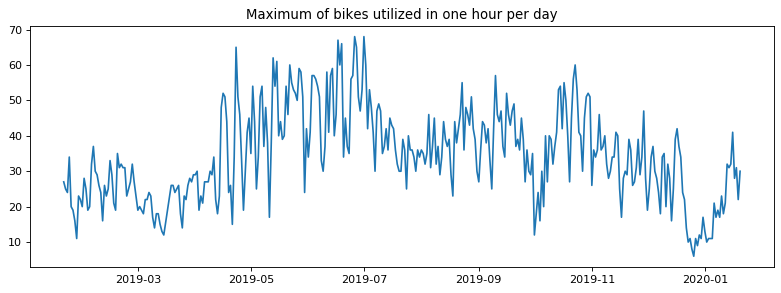

In [8]:
#computing max availaibility per day and plotting it
max_avail = kpi_mar.groupby("date")["util"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Maximum of bikes utilized in one hour per day")
plt.show()

### Duisburg

In [9]:
#Read in data
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
fleet_size = len(duisburg["b_number"].unique())
duisburg
kpi_duis = pd.DataFrame()

In [10]:
#setting start and end date of the trips (start is rounded down hourly)
duisburg["start"] = duisburg.index.floor(freq = "H")
duisburg['end'] = duisburg.index + pd.to_timedelta(duisburg['trip_duration_mins'], unit='m')
duisburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,start,end
datetime,,,,,,,,,,,
2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,2019-05-27 14:00:00,2019-05-27 16:01:00
2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,2019-05-27 17:00:00,2019-05-27 18:04:00
2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,2019-05-28 08:00:00,2019-05-28 08:25:00
2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,2019-06-04 09:00:00,2019-06-04 09:25:00
2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,2019-06-05 09:00:00,2019-06-05 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 07:14:00,2020-01-20,07:14:00,501597,duisburg,"(51.4273, 6.7978)","(51.4294, 6.7772)",0,7,21,2020-01-20 07:00:00,2020-01-20 07:35:00
2020-01-20 10:08:00,2020-01-20,10:08:00,501597,duisburg,"(51.4294, 6.7772)","(51.4284, 6.8004)",0,10,10,2020-01-20 10:00:00,2020-01-20 10:18:00
2020-01-20 19:39:00,2020-01-20,19:39:00,501597,duisburg,"(51.4284, 6.8004)","(51.4294, 6.7772)",0,19,11,2020-01-20 19:00:00,2020-01-20 19:50:00


In [11]:
#computing availablility by grouping by datetime and checking the number of diiferent bike numbers
kpi_duis["util"]  = duisburg.groupby("start")["b_number"].nunique()
kpi_duis["util"]

start
2019-01-20 00:00:00     1
2019-01-20 01:00:00     3
2019-01-20 05:00:00     1
2019-01-20 06:00:00     4
2019-01-20 07:00:00     1
                       ..
2020-01-20 19:00:00    14
2020-01-20 20:00:00    15
2020-01-20 21:00:00    10
2020-01-20 22:00:00     5
2020-01-20 23:00:00     4
Name: util, Length: 8288, dtype: int64

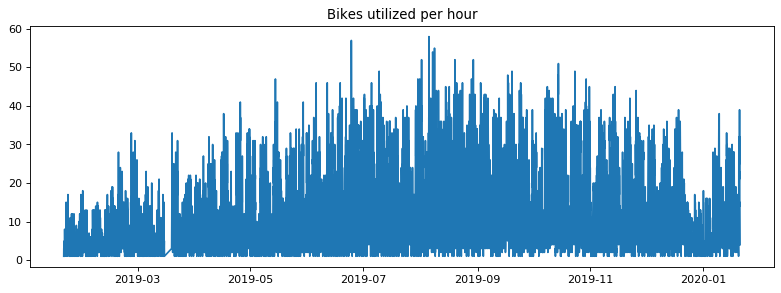

In [12]:
#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_duis["util"])
ax.set_title("Bikes utilized per hour")
plt.show()

In [13]:
#creating day column
kpi_duis["date"] = kpi_duis.index.date
kpi_duis

,util,date
start,,
2019-01-20 00:00:00,1,2019-01-20
2019-01-20 01:00:00,3,2019-01-20
2019-01-20 05:00:00,1,2019-01-20
2019-01-20 06:00:00,4,2019-01-20
2019-01-20 07:00:00,1,2019-01-20
...,...,...
2020-01-20 19:00:00,14,2020-01-20
2020-01-20 20:00:00,15,2020-01-20
2020-01-20 21:00:00,10,2020-01-20


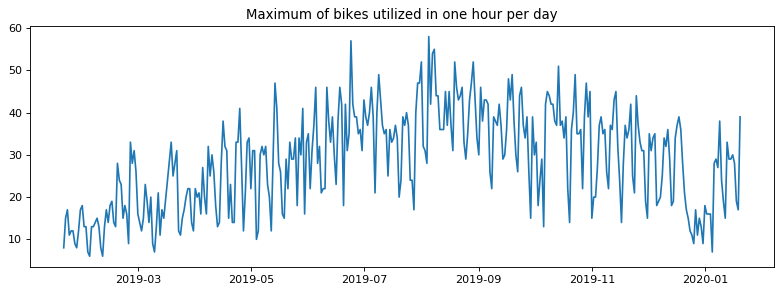

In [14]:
#computing max availaibility per day and plotting it
max_avail = kpi_duis.groupby("date")["util"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Maximum of bikes utilized in one hour per day")
plt.show()

## Fleet distance traveled (Tim)

This KPI covers the sum of all kilometres traveled by all bikes in the span of an hour. To do that, we have to calculate the distance of each individual ride, which we then sum up to visualize the distance traveled by the entire fleet in the span for each hour.

### Adding trip_distance for each ride:

Let us start with Marburg first.

In [15]:
# Reading the clean pickle file.

marburg = pd.read_pickle('../0_data/marburg_clean.pkl')

# Here is an overview:

marburg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164057 entries, 2019-07-04 13:29:00 to 2019-05-20 09:38:00
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   day                 164057 non-null  datetime64[ns]
 1   time                164057 non-null  object        
 2   b_number            164057 non-null  int64         
 3   city                164057 non-null  object        
 4   orig                164057 non-null  object        
 5   dest                164057 non-null  object        
 6   weekday             164057 non-null  int64         
 7   hour                164057 non-null  int64         
 8   trip_duration_mins  164057 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 12.5+ MB


In [16]:
# Here we are extracting the latitude and longitude values from the origin and destination coordinates, so
# we can use them indiviudally when calculating the distance between the two coordinates.
# To do this we are using the zip* function.

marburg["lat_orig_test"], marburg["lon_orig_test"] =  zip(*marburg["orig"])
marburg["lat_dest_test"], marburg["lon_dest_test"] =  zip(*marburg["dest"])

#This is what the dataframe looks like now:

marburg.head(10)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,lat_orig_test,lon_orig_test,lat_dest_test,lon_dest_test
datetime,,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,50.8081,8.7754,50.8110,8.7742
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,50.7987,8.7530,50.8058,8.7828
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,50.8058,8.7828,50.8229,8.7747
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,50.8200,8.7737,50.7856,8.7794
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,50.7856,8.7794,50.7952,8.7633
2019-07-07 11:49:00,2019-07-07,11:49:00,11070,marburg,"(50.7952, 8.7633)","(50.8089, 8.773)",6,11,18,50.7952,8.7633,50.8089,8.7730
2019-07-07 13:11:00,2019-07-07,13:11:00,11070,marburg,"(50.8089, 8.773)","(50.8167, 8.7812)",6,13,13,50.8089,8.7730,50.8167,8.7812
2019-07-07 14:02:00,2019-07-07,14:02:00,11070,marburg,"(50.8167, 8.7812)","(50.8229, 8.7747)",6,14,16,50.8167,8.7812,50.8229,8.7747
2019-07-07 14:26:00,2019-07-07,14:26:00,11070,marburg,"(50.8229, 8.7747)","(50.8137, 8.7707)",6,14,15,50.8229,8.7747,50.8137,8.7707


In [17]:
# Next, we are defining a function called 'distance', which calculates the distance between two latitude and longitude values.
# This function also factors in the curve of the earth instead of just computing the exact distance.

def distance(lat1, lon1, lat2, lon2):
    
    radius = 6371 # km, we have to adjust to the earths curvature so we have to input the radius of the earth as well.
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d


In [18]:
# Here we are getting the values of the latitude and longitude of the origin and destination without the index and save it
# in individual arrays, so we can access these values easily for the 'distance' function.

array_lat_orig = marburg.loc[:, 'lat_orig_test'].values
array_lon_orig = marburg.loc[:, 'lon_orig_test'].values
array_lat_dest = marburg.loc[:, 'lat_dest_test'].values
array_lon_dest = marburg.loc[:, 'lon_dest_test'].values


In [19]:
# We are using a simple for loop to calculate the distance between the origin and destination for every single ride, which we
# then save as an array 'b'.
# Afterwards we save this distance in a new column called 'trip_distance'
a = len(marburg)
b = [0]*a

for i in range(a):
    b[i] = distance(array_lat_orig[i], array_lon_orig[i], array_lat_dest[i], array_lon_dest[i])
    
marburg["trip_distance"] = b

# Here is what the dataframe looks like now.

marburg.head(10)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,lat_orig_test,lon_orig_test,lat_dest_test,lon_dest_test,trip_distance
datetime,,,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,50.8081,8.7754,50.8110,8.7742,0.333306
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,50.7987,8.7530,50.8058,8.7828,2.238067
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,50.8058,8.7828,50.8229,8.7747,1.984767
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,50.8200,8.7737,50.7856,8.7794,3.846022
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,50.7856,8.7794,50.7952,8.7633,1.555723
2019-07-07 11:49:00,2019-07-07,11:49:00,11070,marburg,"(50.7952, 8.7633)","(50.8089, 8.773)",6,11,18,50.7952,8.7633,50.8089,8.7730,1.668932
2019-07-07 13:11:00,2019-07-07,13:11:00,11070,marburg,"(50.8089, 8.773)","(50.8167, 8.7812)",6,13,13,50.8089,8.7730,50.8167,8.7812,1.041233
2019-07-07 14:02:00,2019-07-07,14:02:00,11070,marburg,"(50.8167, 8.7812)","(50.8229, 8.7747)",6,14,16,50.8167,8.7812,50.8229,8.7747,0.826912
2019-07-07 14:26:00,2019-07-07,14:26:00,11070,marburg,"(50.8229, 8.7747)","(50.8137, 8.7707)",6,14,15,50.8229,8.7747,50.8137,8.7707,1.060886


In [20]:
# Now that we have the distance of each individual ride, we can once again drop the latitude and longitude values for 
# the origin and destination to clean up the dataframe a bit.

marburg.drop(columns=['lat_orig_test','lon_orig_test','lat_dest_test','lon_dest_test'], axis=1, inplace = True)

# Looks a lot better, doesn't it?

marburg.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,trip_distance
datetime,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,0.333306
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,2.238067
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,1.984767
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,3.846022
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,1.555723


In [21]:
# Here we are doing what we just did to the Duisburg data as well.

duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')

duisburg["lat_orig_test"], duisburg["lon_orig_test"] =  zip(*duisburg["orig"])
duisburg["lat_dest_test"], duisburg["lon_dest_test"] =  zip(*duisburg["dest"])

array_lat_orig_2 = duisburg.loc[:, 'lat_orig_test'].values
array_lon_orig_2 = duisburg.loc[:, 'lon_orig_test'].values
array_lat_dest_2 = duisburg.loc[:, 'lat_dest_test'].values
array_lon_dest_2 = duisburg.loc[:, 'lon_dest_test'].values

a = len(duisburg)
c = [0]*a

for i in range(a):
    c[i] = distance(array_lat_orig_2[i], array_lon_orig_2[i], array_lat_dest_2[i], array_lon_dest_2[i])
    
duisburg["trip_distance"] = c

duisburg.drop(columns=['lat_orig_test','lon_orig_test','lat_dest_test','lon_dest_test'], axis=1, inplace = True)

# Now the dataframe looks the same as the one for Marburg (with the trip_distance included).

duisburg.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,trip_distance
datetime,,,,,,,,,,
2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,1.457762
2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,1.869223
2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,0.678440
2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,0.390406
2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,1.869075


# Visualizing the distance covered:

Let's start with the Marburg data first again.

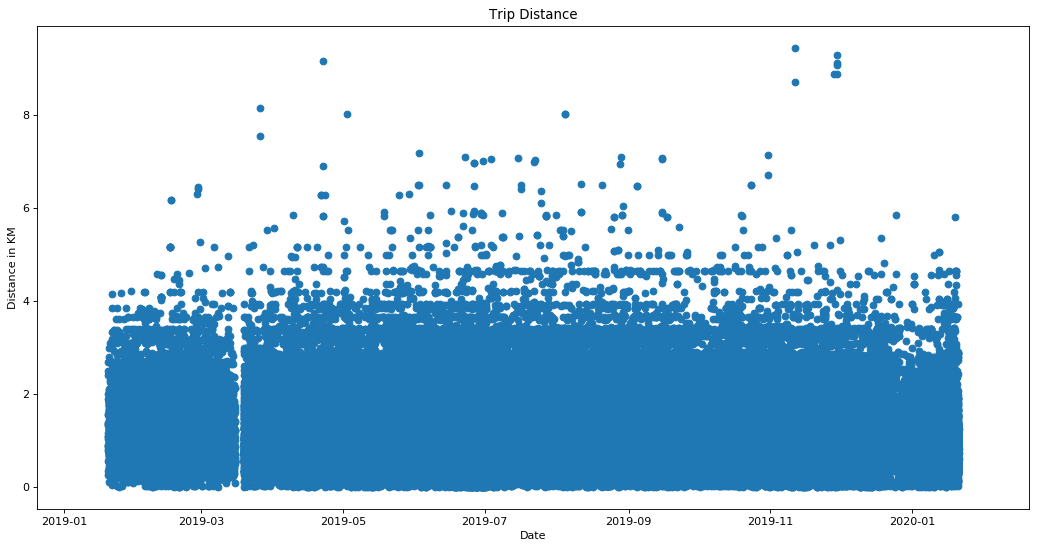

In [23]:
# We start by creating a new column called 'start', that we'll need later to
# sum up all the rides that take place in a single hour.

marburg['start'] = marburg.index.floor(freq = "H")
#marburg['end'] = marburg.index + pd.to_timedelta(marburg['trip_duration_mins'], unit='m')

# Let's create a simple scatter plot to show all of the distances of each individual ride.

fig,ax = plt.subplots(figsize=(16,8), dpi= 80) 
ax.scatter(marburg["start"], marburg["trip_distance"])
ax.set_title("Trip Distance")
ax.set_xlabel("Date")
ax.set_ylabel("Distance in KM")
plt.show()

In [24]:
# Here we create a new Dataframe to sum up the trip_distances of all rides that took place in one hour

hourly_distance_marburg = pd.DataFrame()
hourly_distance_marburg["distance"] = marburg["trip_distance"].groupby(marburg["start"]).sum()

# This is what the Dataframe looks like

hourly_distance_marburg.head(10)

,distance
start,
2019-01-20 00:00:00,8.413924
2019-01-20 01:00:00,12.283895
2019-01-20 02:00:00,5.552752
2019-01-20 03:00:00,0.559740
2019-01-20 04:00:00,2.730626
2019-01-20 05:00:00,1.608936
2019-01-20 06:00:00,1.286251
2019-01-20 07:00:00,4.745243
2019-01-20 08:00:00,4.215268


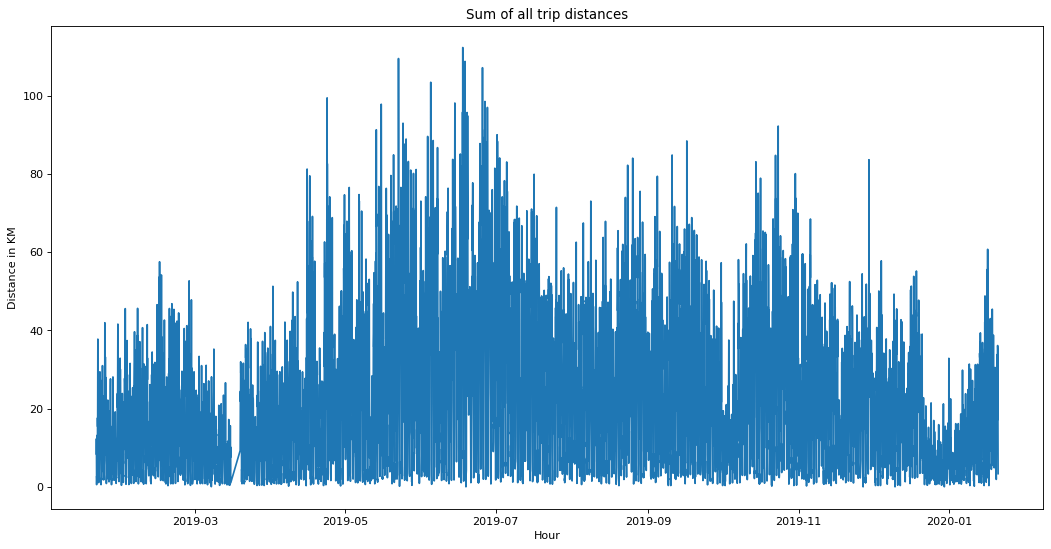

In [25]:
# Now, let us visualize this KPI, which is the total distance traveled by all bikes in the span of an hour.

fig,ax = plt.subplots(figsize=(16,8), dpi= 80) 
ax.plot(hourly_distance_marburg["distance"])
ax.set_title("Sum of all trip distances")
ax.set_xlabel("Hour")
ax.set_ylabel("Distance in KM")
plt.show()

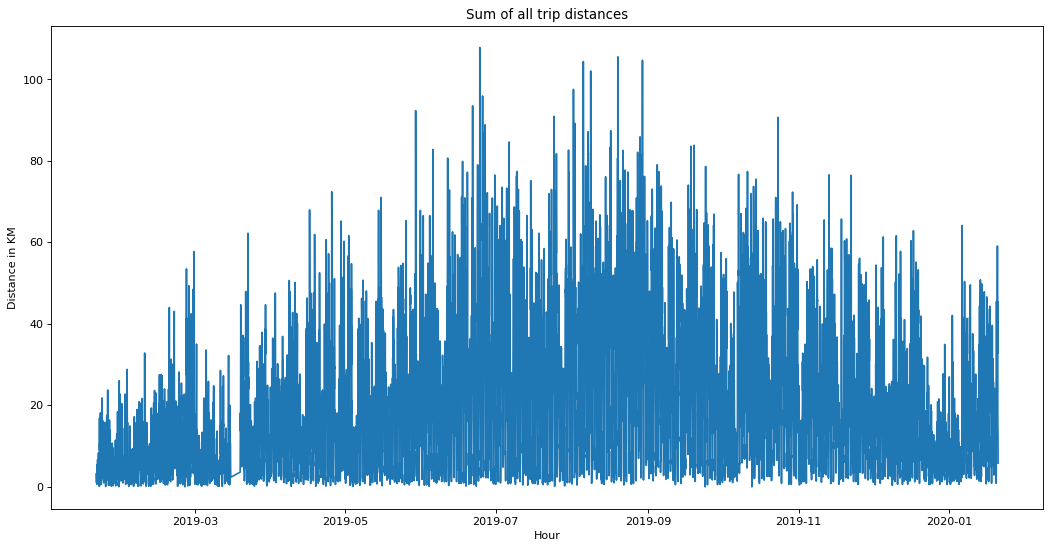

In [26]:
# We will once again repeat this for the Duisburg data.

duisburg['start'] = duisburg.index.floor(freq = "H")
hourly_distance_duisburg = pd.DataFrame()
hourly_distance_duisburg["distance"] = duisburg["trip_distance"].groupby(duisburg["start"]).sum()
fig,ax = plt.subplots(figsize=(16,8), dpi= 80) 
ax.plot(hourly_distance_duisburg["distance"])
ax.set_title("Sum of all trip distances")
ax.set_xlabel("Hour")
ax.set_ylabel("Distance in KM")
plt.show()

## Quality of fleet (Julia)

_Briefly explain the rationale behind each KPI and why you have chosen it_

Another key performance indicator is the quality of the bikes.   
We can assume that if a bike is not used for 4 weeks or longer it is probably broken or can't be accessed.
The percentage of bikes that overstep this threshold value can tells us the quality of the fleet.

_Calculate hourly KPIs for the two cities in your dataset and visualize them over time._

In [27]:
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')

## Duisburg

In [28]:
duisburg = duisburg.sort_values(['datetime']) #first we sort the values by time
duisburg = duisburg.reset_index() #and reset the index because we need the datetimecolumn
duisburg

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins
0,2019-01-20 00:31:00,2019-01-20,00:31:00,51129,duisburg,"(51.4393, 6.7829)","(51.4294, 6.7772)",6,0,10
1,2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13
2,2019-01-20 01:21:00,2019-01-20,01:21:00,51465,duisburg,"(51.4281, 6.7792)","(51.432, 6.7712)",6,1,121
3,2019-01-20 01:54:00,2019-01-20,01:54:00,51129,duisburg,"(51.4304, 6.7748)","(51.4223, 6.7918)",6,1,9
4,2019-01-20 05:37:00,2019-01-20,05:37:00,51299,duisburg,"(51.4294, 6.7772)","(51.4245, 6.7815)",6,5,6
...,...,...,...,...,...,...,...,...,...,...
131914,2020-01-20 22:48:00,2020-01-20,22:48:00,52171,duisburg,"(51.4283, 6.7856)","(51.4294, 6.7772)",0,22,6
131915,2020-01-20 23:22:00,2020-01-20,23:22:00,51585,duisburg,"(51.4558, 6.735)","(51.4367, 6.7576)",0,23,15
131916,2020-01-20 23:24:00,2020-01-20,23:24:00,501570,duisburg,"(51.4319, 6.7784)","(51.4302, 6.762)",0,23,7
131917,2020-01-20 23:33:00,2020-01-20,23:33:00,501533,duisburg,"(51.4104, 6.7521)","(51.4178, 6.7575)",0,23,18


In [29]:
def calc_length(df): #we compute the difference between the datetimes 
    df['diff'] = df['datetime'].diff(periods=-1) #periods=-1 asssures that we use the row under the current one 
    return df

In [30]:
#now we apply the calculation od the difference grouped by bike
duisburg_diff = duisburg.groupby(['b_number'], sort=False).apply(calc_length)
duisburg_diff

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff
0,2019-01-20 00:31:00,2019-01-20,00:31:00,51129,duisburg,"(51.4393, 6.7829)","(51.4294, 6.7772)",6,0,10,-1 days +22:37:00
1,2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13,-165 days +19:00:00
2,2019-01-20 01:21:00,2019-01-20,01:21:00,51465,duisburg,"(51.4281, 6.7792)","(51.432, 6.7712)",6,1,121,-2 days +18:43:00
3,2019-01-20 01:54:00,2019-01-20,01:54:00,51129,duisburg,"(51.4304, 6.7748)","(51.4223, 6.7918)",6,1,9,-1 days +19:41:00
4,2019-01-20 05:37:00,2019-01-20,05:37:00,51299,duisburg,"(51.4294, 6.7772)","(51.4245, 6.7815)",6,5,6,-1 days +17:31:00
...,...,...,...,...,...,...,...,...,...,...,...
131914,2020-01-20 22:48:00,2020-01-20,22:48:00,52171,duisburg,"(51.4283, 6.7856)","(51.4294, 6.7772)",0,22,6,NaT
131915,2020-01-20 23:22:00,2020-01-20,23:22:00,51585,duisburg,"(51.4558, 6.735)","(51.4367, 6.7576)",0,23,15,NaT
131916,2020-01-20 23:24:00,2020-01-20,23:24:00,501570,duisburg,"(51.4319, 6.7784)","(51.4302, 6.762)",0,23,7,NaT
131917,2020-01-20 23:33:00,2020-01-20,23:33:00,501533,duisburg,"(51.4104, 6.7521)","(51.4178, 6.7575)",0,23,18,NaT


In [31]:
# An example to show that it worked
duisburg_diff.sort_values(['b_number','datetime'])[duisburg_diff['b_number']==683]

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff
27613,2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,-1 days +21:28:00
27675,2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,-1 days +09:01:00
27829,2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,-8 days +23:06:00
30425,2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,-1 days +00:05:00
30907,2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,-1 days +22:33:00
30940,2019-06-05 10:35:00,2019-06-05,10:35:00,683,duisburg,"(51.4393, 6.7829)","(51.4306, 6.7735)",2,10,41,NaT


The timedeltas are negative because we calculated backwards.  
Also we can see that the last entry of course is Nat because we had no more rows to compute it. That's why we now compute it with the time of the last dataentry. 

In [32]:
duisburg['datetime'].max() #latest datetime

Timestamp('2020-01-20 23:48:00')

In [41]:
def fill_NaT(row): #fills the rows with NaT
    if pd.isnull(row['diff']):
        end = pd.Timestamp(year=2020, month=1, day=21)
        row['diff'] = row['datetime'] - end
    return row

In [42]:
duisburg_diff = duisburg_diff.apply(fill_NaT, axis=1) #we apply our fill_NaT method

In [43]:
#again an example to look if it worked
duisburg_diff[duisburg_diff['b_number']==683]

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff
27613,2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,-1 days +21:28:00
27675,2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,-1 days +09:01:00
27829,2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,-8 days +23:06:00
30425,2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,-1 days +00:05:00
30907,2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,-1 days +22:33:00
30940,2019-06-05 10:35:00,2019-06-05,10:35:00,683,duisburg,"(51.4393, 6.7829)","(51.4306, 6.7735)",2,10,41,229 days 13:25:00


The last entry is not negative so we have to consider this.

In [50]:
#Every bike that was not used longer than 28 days
duisburg_diff['is_broken'] = (duisburg_diff['diff'] < timedelta(days=-28)) | (duisburg_diff['diff'] > timedelta(days=28))

In [51]:
duisburg_diff[duisburg_diff['b_number']==683] #example bike

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken
27613,2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,-1 days +21:28:00,False
27675,2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,-1 days +09:01:00,False
27829,2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,-8 days +23:06:00,False
30425,2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,-1 days +00:05:00,False
30907,2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,-1 days +22:33:00,False
30940,2019-06-05 10:35:00,2019-06-05,10:35:00,683,duisburg,"(51.4393, 6.7829)","(51.4306, 6.7735)",2,10,41,229 days 13:25:00,True


Now there is a binary factor stating whether a bike is broken.

In [52]:
duisburg_diff = duisburg_diff.set_index('datetime') #setting the index to the datetimecolumn again
duisburg_diff

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken
datetime,,,,,,,,,,,
2019-01-20 00:31:00,2019-01-20,00:31:00,51129,duisburg,"(51.4393, 6.7829)","(51.4294, 6.7772)",6,0,10,-1 days +22:37:00,False
2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13,-165 days +19:00:00,True
2019-01-20 01:21:00,2019-01-20,01:21:00,51465,duisburg,"(51.4281, 6.7792)","(51.432, 6.7712)",6,1,121,-2 days +18:43:00,False
2019-01-20 01:54:00,2019-01-20,01:54:00,51129,duisburg,"(51.4304, 6.7748)","(51.4223, 6.7918)",6,1,9,-1 days +19:41:00,False
2019-01-20 05:37:00,2019-01-20,05:37:00,51299,duisburg,"(51.4294, 6.7772)","(51.4245, 6.7815)",6,5,6,-1 days +17:31:00,False
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 22:48:00,2020-01-20,22:48:00,52171,duisburg,"(51.4283, 6.7856)","(51.4294, 6.7772)",0,22,6,0 days 01:12:00,False
2020-01-20 23:22:00,2020-01-20,23:22:00,51585,duisburg,"(51.4558, 6.735)","(51.4367, 6.7576)",0,23,15,0 days 00:38:00,False
2020-01-20 23:24:00,2020-01-20,23:24:00,501570,duisburg,"(51.4319, 6.7784)","(51.4302, 6.762)",0,23,7,0 days 00:36:00,False


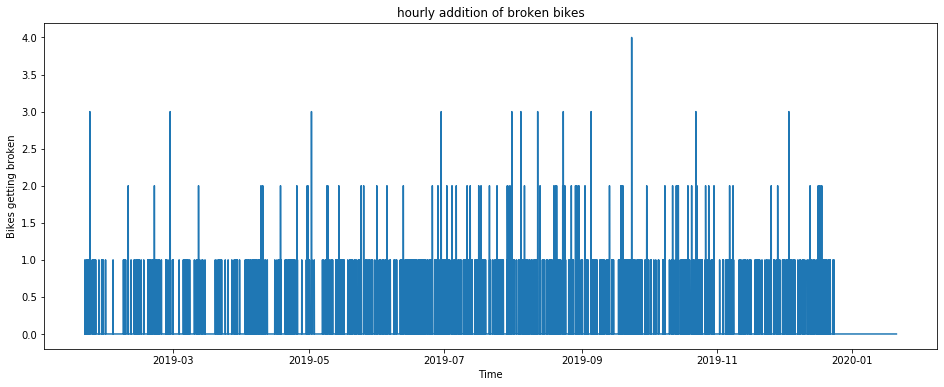

In [54]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(duisburg_diff.resample('h')['is_broken'].sum()) #plotting the bikes getting broken per hour
ax.set_title("hourly addition of broken bikes")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

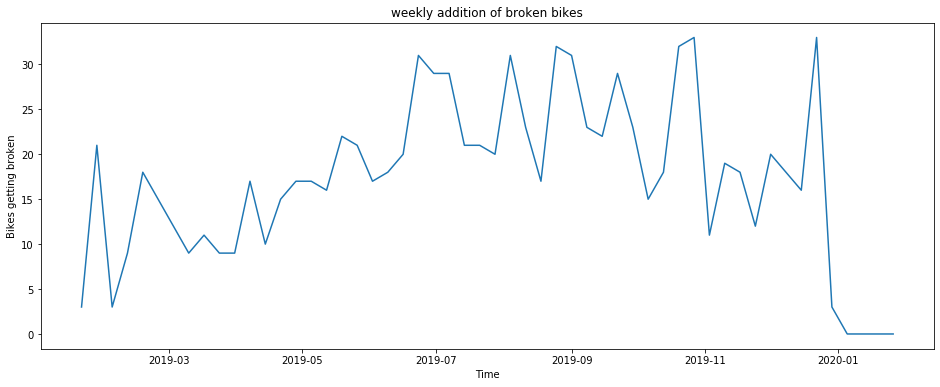

In [55]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(duisburg_diff.resample('w')['is_broken'].sum()) #plotting the bikes getting broken per week
ax.set_title("weekly addition of broken bikes")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

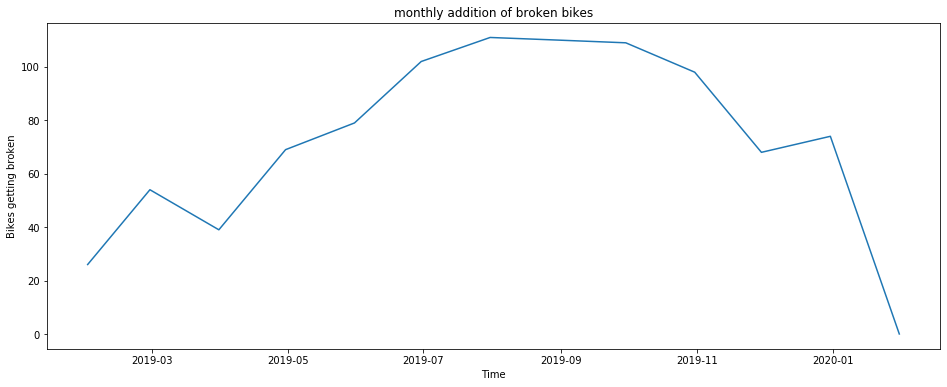

In [56]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(duisburg_diff.resample('m')['is_broken'].sum()) #plotting the bikes getting broken per month
ax.set_title("monthly addition of broken bikes")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

In [57]:
duisburg_diff.resample('m')['is_broken'].sum() #to see the exact values

datetime
2019-01-31     26.0
2019-02-28     54.0
2019-03-31     39.0
2019-04-30     69.0
2019-05-31     79.0
2019-06-30    102.0
2019-07-31    111.0
2019-08-31    110.0
2019-09-30    109.0
2019-10-31     98.0
2019-11-30     68.0
2019-12-31     74.0
2020-01-31      0.0
Freq: M, Name: is_broken, dtype: float64

_Which trends do you observe? How do you explain them?_

The Trend of the Bikes getting broken in a week is an up and down with peaks around 30 broken bikes per week.   
When we take a look at the monthly curve we can see that around november until may there are less broken bikes per month (<98) than in the more summmerly months.

In [64]:
duisburg_diff_true = duisburg_diff[duisburg_diff['is_broken']==True] # a dataframe with only broken bikes entries
duisburg_diff_true["cumulative_broken_bikes"] = range(0,len(duisburg_diff_true), 1) #counting the broken bikes over the year
duisburg_diff_true

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken,cumulative_broken_bikes
datetime,,,,,,,,,,,,
2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13,-165 days +19:00:00,True,0
2019-01-20 16:52:00,2019-01-20,16:52:00,53061,duisburg,"(51.4319, 6.7784)","(51.4223, 6.7918)",6,16,11,365 days 07:08:00,True,1
2019-01-20 22:44:00,2019-01-20,22:44:00,53307,duisburg,"(51.4294, 6.7772)","(51.4347, 6.7698)",6,22,5,-188 days +22:39:00,True,2
2019-01-21 09:08:00,2019-01-21,09:08:00,52119,duisburg,"(51.4302, 6.762)","(51.4272, 6.7977)",0,9,55,-47 days +01:44:00,True,3
2019-01-21 16:35:00,2019-01-21,16:35:00,52974,duisburg,"(51.4352, 6.7617)","(51.4558, 6.735)",0,16,16,-30 days +06:14:00,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-22 00:47:00,2019-12-22,00:47:00,51034,duisburg,"(51.4319, 6.7784)","(51.4677, 6.7801)",6,0,37,29 days 23:13:00,True,934
2019-12-22 03:45:00,2019-12-22,03:45:00,50510,duisburg,"(51.4319, 6.7784)","(51.4314, 6.7591)",6,3,10,29 days 20:15:00,True,935
2019-12-23 09:52:00,2019-12-23,09:52:00,500973,duisburg,"(51.4273, 6.7978)","(51.4378, 6.7772)",0,9,31,28 days 14:08:00,True,936


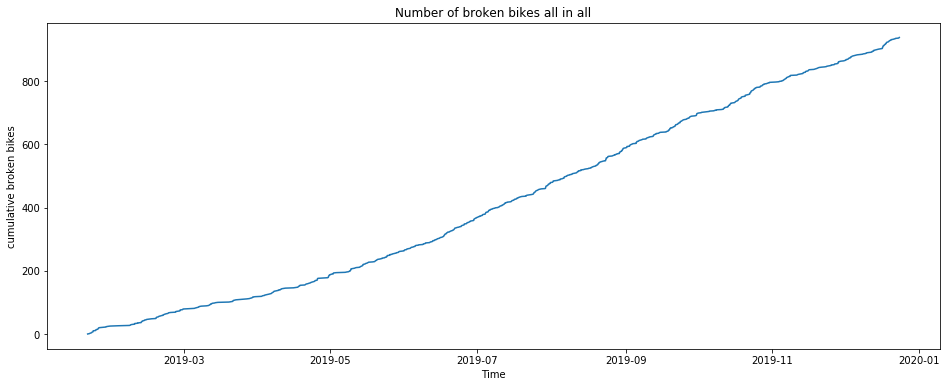

In [65]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(duisburg_diff_true["cumulative_broken_bikes"]) #plotting all broken bikes over the year
ax.set_title("Number of broken bikes all in all")
ax.set_xlabel("Time")
ax.set_ylabel("cumulative broken bikes")

plt.show()

The increase in broken bikes seems to be linear.

## Marburg

In [67]:
#now we do the same as above for marburg
marburg = marburg.sort_values(['datetime'])
marburg = marburg.reset_index()
marburg_diff = marburg.groupby(['b_number'], sort=False).apply(calc_length)
marburg_diff = marburg_diff.apply(fill_NaT, axis=1)
marburg_diff['is_broken'] = (marburg_diff['diff'] < timedelta(days=-28)) | (marburg_diff['diff'] > timedelta(days=28))
marburg_diff = marburg_diff.set_index('datetime')
marburg_diff

,index,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken
datetime,,,,,,,,,,,,
2019-01-20 00:04:00,0,2019-01-20,00:04:00,11181,marburg,"(50.7973, 8.7616)","(50.8081, 8.7753)",6,0,11,-1 days +07:25:00,False
2019-01-20 00:08:00,1,2019-01-20,00:08:00,11126,marburg,"(50.7988, 8.7621)","(50.8132, 8.7759)",6,0,18,-1 days +23:32:00,False
2019-01-20 00:08:00,2,2019-01-20,00:08:00,11103,marburg,"(50.7988, 8.7621)","(50.8045, 8.7704)",6,0,9,-1 days +22:37:00,False
2019-01-20 00:25:00,3,2019-01-20,00:25:00,11113,marburg,"(50.8071, 8.7699)","(50.8047, 8.7592)",6,0,29,-1 days +09:05:00,False
2019-01-20 00:36:00,4,2019-01-20,00:36:00,11126,marburg,"(50.8132, 8.7759)","(50.8132, 8.7633)",6,0,5,-1 days +09:35:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 22:50:00,164052,2020-01-20,22:50:00,11124,marburg,"(50.8165, 8.7792)","(50.8094, 8.7722)",0,22,9,-1 days +22:50:00,False
2020-01-20 23:06:00,164053,2020-01-20,23:06:00,11297,marburg,"(50.8089, 8.773)","(50.82, 8.7737)",0,23,7,-1 days +23:06:00,False
2020-01-20 23:16:00,164054,2020-01-20,23:16:00,11263,marburg,"(50.8016, 8.7597)","(50.7953, 8.762)",0,23,6,-1 days +23:16:00,False


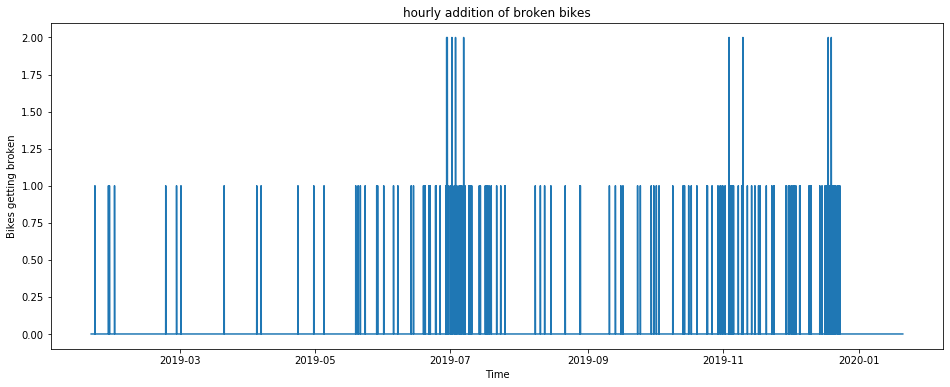

In [69]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(marburg_diff.resample('h')['is_broken'].sum()) #plotting the bikes getting broken per hour
ax.set_title("hourly addition of broken bikes")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

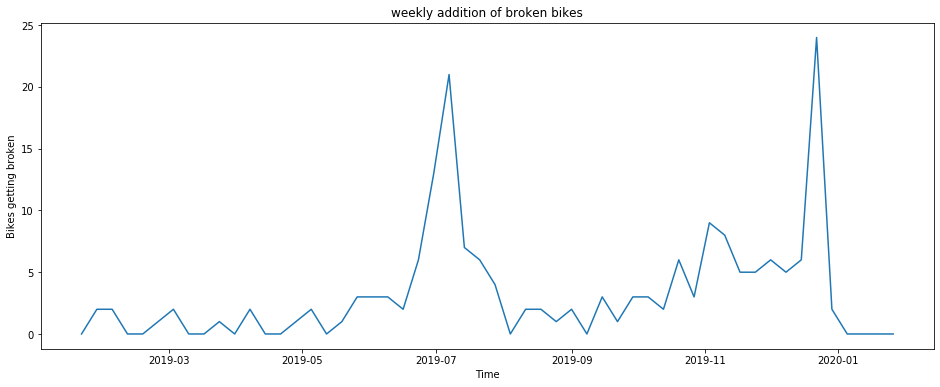

In [70]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(marburg_diff.resample('w')['is_broken'].sum()) #plotting the bikes getting broken per week
ax.set_title("weekly addition of broken bikes")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

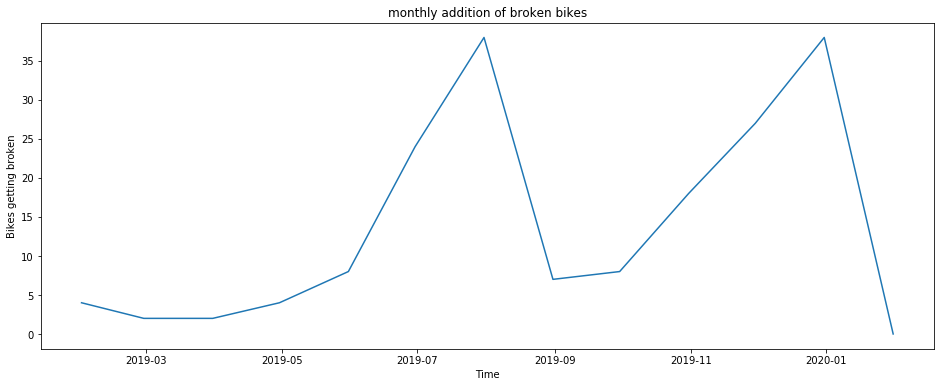

In [71]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(marburg_diff.resample('m')['is_broken'].sum()) #plotting the bikes getting broken per month
ax.set_title("monthly addition of broken bikes")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

In [72]:
marburg_diff.resample('m')['is_broken'].sum() #to see the exact values

datetime
2019-01-31     4.0
2019-02-28     2.0
2019-03-31     2.0
2019-04-30     4.0
2019-05-31     8.0
2019-06-30    24.0
2019-07-31    38.0
2019-08-31     7.0
2019-09-30     8.0
2019-10-31    18.0
2019-11-30    27.0
2019-12-31    38.0
2020-01-31     0.0
Freq: M, Name: is_broken, dtype: float64

_Which trends do you observe? How do you explain them?_

The Trend of the Bikes getting broken in a month in Marburg is low (<10) except for june - july and october - december.   
This could be corrolated with a higher utilization in the summer months and bad weather in the winter months. 
With a higher utilization comes a higher risk of getting a bike broken and in winter rainy weather can also increase the probability of a broken bike. 

In [73]:
marburg_diff_true = marburg_diff[marburg_diff['is_broken']==True] # a dataframe with only broken bikes entries
marburg_diff_true["cumulative_broken_bikes"] = range(0,len(marburg_diff_true), 1) #counting the broken bikes over the year
marburg_diff_true

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken,cumulative_broken_bikes
datetime,,,,,,,,,,,,,
2019-01-21 17:44:00,463,2019-01-21,17:44:00,11196,marburg,"(50.8098, 8.7794)","(50.8089, 8.7731)",0,17,17,-365 days +17:44:00,True,0
2019-01-27 19:14:00,1881,2019-01-27,19:14:00,11214,marburg,"(50.8229, 8.7747)","(50.8136, 8.7737)",6,19,7,-359 days +19:14:00,True,1
2019-01-28 06:55:00,1910,2019-01-28,06:55:00,11108,marburg,"(50.8045, 8.7704)","(50.7988, 8.7621)",0,6,6,-358 days +06:55:00,True,2
2019-01-30 13:35:00,2592,2019-01-30,13:35:00,11272,marburg,"(50.8362, 8.7568)","(50.8229, 8.7747)",2,13,23,-149 days +01:05:00,True,3
2019-02-22 15:09:00,9875,2019-02-22,15:09:00,11189,marburg,"(50.8089, 8.773)","(50.8229, 8.7747)",4,15,10,-333 days +15:09:00,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-22 11:03:00,157641,2019-12-22,11:03:00,11126,marburg,"(50.7988, 8.7621)","(50.82, 8.7737)",6,11,18,-30 days +11:03:00,True,175
2019-12-22 20:10:00,157720,2019-12-22,20:10:00,11199,marburg,"(50.7895, 8.7564)","(50.8033, 8.7641)",6,20,12,-30 days +20:10:00,True,176
2019-12-22 21:54:00,157729,2019-12-22,21:54:00,11081,marburg,"(50.8058, 8.7828)","(50.7988, 8.7621)",6,21,22,-30 days +21:54:00,True,177


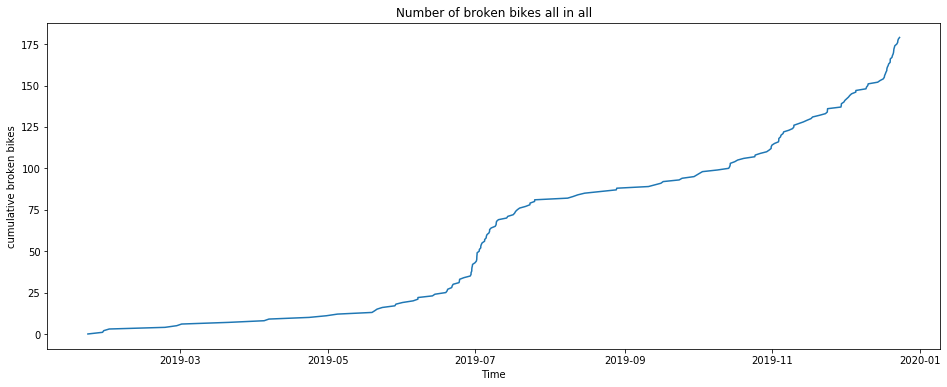

In [75]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(marburg_diff_true["cumulative_broken_bikes"]) #plotting all broken bikes over the year
ax.set_title("Number of broken bikes all in all")
ax.set_xlabel("Time")
ax.set_ylabel("cumulative broken bikes")

plt.show()

Again we can see the increase in broken bikes in Marburg seems to be way higher in june and july than in the other months. Another bigger increase is seen in and around november.

_Find explanations for any differences between cities. Which city performs better/worse and why?_

Marburg all in all has less broken bikes. In Duisburg bikes are getting broken mostly all year whereas Marburg's bikes are getting often broken in the summer months.  
Marburg performs better maybe because it has less citizens (~ 80.000) than duisburg (~ 490.000).  
The high rise of broken bikes in the summer coul be backtraced to the bigger usage of bikes in the summer.

## Spread of fleet / coverage (Moritz)